In [1]:
import os,random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import numpy as np
from src.dataset2016 import load_data
from statistics import mean
from src.utils import *

### Set Random Seed

In [2]:
np.random.seed(1991)

### Read Dataset

In [3]:
rate = 1 # xx% of the training data have label, rate = 2 means 2%.

# Read dataset
filename = '/data/dongxin3/2016.10a/RML2016.10a_dict.pkl'
(mods,snrs,lbl),(X_train,Y_train),(X_train_labeled,Y_train_labeled),(X_val_labeled,Y_val_labeled),(X_test,Y_test),\
    (train_idx,test_idx,train_labeled_idx,val_labeled_idx)\
    = load_data(filename, rate)

# Normalization
X_train, X_train_labeled, X_val_labeled, X_test = normalize_data(X_train, X_train_labeled, X_val_labeled, X_test)

print("# of all training data:", X_train.shape[0])
print("# of all testing data:", X_test.shape[0])
print("# of labeled data:", X_train_labeled.shape[0]+X_val_labeled.shape[0], \
      "( Training:",X_train_labeled.shape[0], "Validation:",X_val_labeled.shape[0],")")

# of all training data: 165000
# of all testing data: 55000
# of labeled data: 1760 ( Training: 1100 Validation: 660 )


### Train Contrastive Learning Model - Simclr

In [5]:
# SimLCR
sim_model, epoch_losses = train_simclr(X_train, batch_size=512, Epoch=100, temperature = 0.1)

Model: "model_simclr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I/Qchannel (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 105, 32)           1568      
_________________________________________________________________
LSTM1 (LSTM)                 (None, 105, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 105, 128)          0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 105, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 105, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)          

### Show Epoch Loss Curve

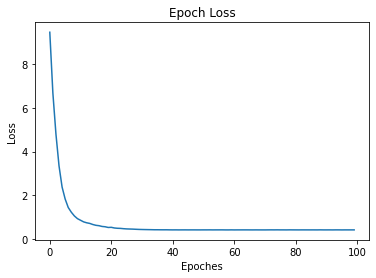

In [4]:
plot_epoch_loss()

### Build a classifier on the output of the encoder and tune the parameter of the encoder with labeled data

In [4]:
# Tune Model
tune_model = train_tune(X_train_labeled, Y_train_labeled, X_val_labeled, Y_val_labeled, X_test, Y_test)

Model: "Tune_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I/Qchannel (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 105, 32)           1568      
_________________________________________________________________
LSTM1 (LSTM)                 (None, 105, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 105, 128)          0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 105, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 105, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           1


Epoch 00035: val_loss did not improve from 1.64052
Epoch 36/200
3/3 - 0s - loss: 1.6445 - accuracy: 0.4145 - val_loss: 1.6809 - val_accuracy: 0.3924

Epoch 00036: val_loss did not improve from 1.64052
Epoch 37/200
3/3 - 0s - loss: 1.6594 - accuracy: 0.4109 - val_loss: 1.6498 - val_accuracy: 0.4076

Epoch 00037: val_loss did not improve from 1.64052
Epoch 38/200
3/3 - 0s - loss: 1.6659 - accuracy: 0.4091 - val_loss: 1.6673 - val_accuracy: 0.4227

Epoch 00038: val_loss did not improve from 1.64052
Epoch 39/200
3/3 - 0s - loss: 1.6321 - accuracy: 0.4045 - val_loss: 1.7059 - val_accuracy: 0.3636

Epoch 00039: val_loss did not improve from 1.64052
Epoch 40/200
3/3 - 0s - loss: 1.6709 - accuracy: 0.4064 - val_loss: 1.6408 - val_accuracy: 0.4242

Epoch 00040: val_loss did not improve from 1.64052
Epoch 41/200
3/3 - 0s - loss: 1.6059 - accuracy: 0.4264 - val_loss: 1.6623 - val_accuracy: 0.4106

Epoch 00041: val_loss did not improve from 1.64052
Epoch 42/200
3/3 - 0s - loss: 1.6042 - accuracy:

3/3 - 0s - loss: 1.4682 - accuracy: 0.4891 - val_loss: 1.6300 - val_accuracy: 0.4318

Epoch 00087: val_loss did not improve from 1.60440
Epoch 88/200
3/3 - 0s - loss: 1.4757 - accuracy: 0.4809 - val_loss: 1.6248 - val_accuracy: 0.4273

Epoch 00088: val_loss did not improve from 1.60440
Epoch 89/200
3/3 - 0s - loss: 1.4619 - accuracy: 0.4800 - val_loss: 1.6244 - val_accuracy: 0.4258

Epoch 00089: val_loss did not improve from 1.60440
Epoch 90/200
3/3 - 0s - loss: 1.4686 - accuracy: 0.4700 - val_loss: 1.5965 - val_accuracy: 0.4394

Epoch 00090: val_loss improved from 1.60440 to 1.59651, saving model to ./saved_models/weight_tune.hdf5
Epoch 91/200
3/3 - 0s - loss: 1.4733 - accuracy: 0.4727 - val_loss: 1.6021 - val_accuracy: 0.4242

Epoch 00091: val_loss did not improve from 1.59651
Epoch 92/200
3/3 - 0s - loss: 1.4246 - accuracy: 0.5018 - val_loss: 1.6375 - val_accuracy: 0.4273

Epoch 00092: val_loss did not improve from 1.59651
Epoch 93/200
3/3 - 0s - loss: 1.4716 - accuracy: 0.4818 - va

### Train the encoder + classifier from the very beginning under supervised way

In [5]:
sup_model = train_supervised(X_train_labeled, Y_train_labeled, X_val_labeled, Y_val_labeled, X_test, Y_test)

Model: "Sup_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I/Qchannel (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 105, 32)           1568      
_________________________________________________________________
LSTM1 (LSTM)                 (None, 105, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 105, 128)          0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 105, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 105, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           13


Epoch 00035: val_loss did not improve from 1.74022
Epoch 36/500
3/3 - 0s - loss: 1.7657 - accuracy: 0.3500 - val_loss: 1.8046 - val_accuracy: 0.3394

Epoch 00036: val_loss did not improve from 1.74022
Epoch 37/500
3/3 - 0s - loss: 1.7449 - accuracy: 0.3564 - val_loss: 1.8055 - val_accuracy: 0.3545

Epoch 00037: val_loss did not improve from 1.74022
Epoch 38/500
3/3 - 0s - loss: 1.7787 - accuracy: 0.3545 - val_loss: 1.7628 - val_accuracy: 0.3773

Epoch 00038: val_loss did not improve from 1.74022
Epoch 39/500
3/3 - 0s - loss: 1.7024 - accuracy: 0.3764 - val_loss: 1.8857 - val_accuracy: 0.3258

Epoch 00039: val_loss did not improve from 1.74022
Epoch 40/500
3/3 - 0s - loss: 1.7101 - accuracy: 0.3664 - val_loss: 1.8196 - val_accuracy: 0.3394

Epoch 00040: val_loss did not improve from 1.74022
Epoch 41/500
3/3 - 0s - loss: 1.7087 - accuracy: 0.3682 - val_loss: 1.7880 - val_accuracy: 0.3333

Epoch 00041: val_loss did not improve from 1.74022

Epoch 00041: ReduceLROnPlateau reducing learnin


Epoch 00087: val_loss did not improve from 1.69391

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.004095999523997307.
Epoch 00087: early stopping
=========== Supervised Training Completed! ==========
Save model to 'saved_models/weight_sup.hdf5'


### Compare the result of our model and the supervised training results

108/108 [==============================] - 2s 12ms/step - loss: 1.6183 - accuracy: 0.4254
Tuned model score: [1.6183435916900635, 0.4254363775253296]
108/108 [==============================] - 2s 11ms/step - loss: 1.6820 - accuracy: 0.3877
Supervised model score: [1.6820265054702759, 0.3876909017562866]


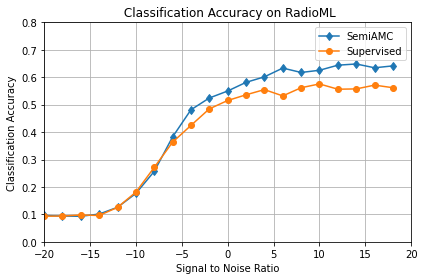

In [5]:
weight_tune = "./saved_models/weight_tune.hdf5"
weight_sup = "./saved_models/weight_sup.hdf5"

compare_tune_and_sup(weight_tune, weight_sup, X_test, Y_test, test_idx, snrs, lbl)